# maxvogt-analysis: Oberrieden

The code in this notebook is based on [Martin Fleischmann's](https://martinfleischmann.net/) 2021 workshop [*Capturing the Structure of Cities with Data Science (SDSC)*](https://github.com/martinfleis/sdsc21-workshop), licensed under the [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/). © 2021 Martin Fleischmann.

The geodata in this notebook is retrieved from OpenStreetMap. © OpenStreetMap Contributors.

<hr>

This notebook contains geodata and analyses for the following items of the [Max Vogt collection](https://mtwente.github.io/maxvogt/) by Moritz Twente and Luisa Omonsky:
- [ORDD018](https://mtwente.github.io/maxvogt/items/ordd018.html)
- [ORDD118](https://mtwente.github.io/maxvogt/items/ordd118.html)

<hr>

Open in an interactive in-browser environment: 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mtwente/maxvogt-analysis/main?labpath=analysis%2Foberrieden.ipynb)

In [1]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

Pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [2]:
place = 'Oberrieden, Schweiz'
local_crs = 'EPSG:2056'

In [3]:
geopandas.tools.geocode(place).explore()

## Input data

Download data from OpenStreetMap.

### Buildings

In [4]:
buildings = osmnx.features.features_from_place(place, tags={'building':True})

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/sit

In [5]:
buildings

amenity operator  \
element_type osmid                         
way          31755377       NaN      NaN   
             44115919       NaN      NaN   
             44115920       NaN      NaN   
             44115921       NaN      NaN   
             44115922       NaN      NaN   
...                         ...      ...   
             1261816540     NaN      NaN   
             1261893913     NaN      NaN   
             1261899058     NaN      NaN   
             1261899064     NaN      NaN   
             1292857527     NaN      NaN   

                                                                  geometry  \
element_type osmid                                                           
way          31755377    POLYGON ((8.57482 47.27620, 8.57491 47.27608, ...   
             44115919    POLYGON ((8.57961 47.27624, 8.57967 47.27616, ...   
             44115920    POLYGON ((8.57739 47.27437, 8.57751 47.27431, ...   
             44115921    POLYGON ((8.57746 47.27477, 8.57759 47.27471, ...   
             44115922    POLYGON ((8.57764 47.27431, 8.57777 47.27424, ...   
...                                                                    ...   
             1261816540  POLYGON ((8.57396 47.27933, 8.57397 47.27939, ...   
             1261893913  POLYGON ((8.57831 47.27198, 8.57825 47.27191, ...   
             1261899058  POLYGON ((8.57988 47.27071, 8.57990 47.27074, ...   
             1261899064  POLYGON ((8.57984 47.27064, 8.57989 47.27067, ...   
             1292857527  POLYGON ((8.57773 47.27669, 8.57780 47.27660, ...   

                                           name tourism addr:housenumber  \
element_type osmid                                                         
way          31755377    Sekundarschule Langweg     NaN                2   
             44115919                       NaN     NaN               42   
             44115920                       NaN     NaN                3   
             44115921                       NaN     NaN                5   
             44115922                       NaN     NaN                1   
...                                         ...     ...              ...   
             1261816540                     NaN     NaN              NaN   
             1261893913                     NaN     NaN              NaN   
             1261899058                     NaN     NaN              NaN   
             1261899064                     NaN     NaN              NaN   
             1292857527                     NaN     NaN              NaN   

                                  addr:street   addr:city addr:postcode  \
element_type osmid                                                        
way          31755377                 Langweg  Oberrieden          8942   
             44115919             Fachstrasse         NaN           NaN   
             44115920    Schäppi-Naef-Strasse  Oberrieden          8942   
             44115921    Schäppi-Naef-Strasse  Oberrieden          8942   
             44115922    Schäppi-Naef-Strasse  Oberrieden          8942   
...                                       ...         ...           ...   
             1261816540                   NaN         NaN           NaN   
             1261893913                   NaN         NaN           NaN   
             1261899058                   NaN         NaN           NaN   
             1261899064                   NaN         NaN           NaN   
             1292857527                   NaN         NaN           NaN   

                                                                     nodes  \
element_type osmid                                                           
way          31755377    [355401234, 355401236, 355401237, 355401239, 3...   
             44115919    [560596572, 560596573, 560596574, 560596575, 5...   
             44115920    [560596527, 560596528, 560596541, 560596544, 5...   
             44115921    [560596531, 560596545, 560596532, 560596533, 5...   
   

In [6]:
buildings.geom_type.value_counts()

Polygon    844
Name: count, dtype: int64

In [7]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

In [8]:
buildings = buildings[["geometry"]].to_crs(local_crs)

In [9]:
buildings["uID"] = range(len(buildings))

In [10]:
buildings

,geometry,uID
0,"POLYGON ((2685966.871 1236766.632, 2685974.033...",0
1,"POLYGON ((2686329.483 1236775.808, 2686333.764...",1
2,"POLYGON ((2686164.572 1236566.019, 2686173.696...",2
3,"POLYGON ((2686169.357 1236610.209, 2686178.804...",3
4,"POLYGON ((2686183.476 1236559.222, 2686193.194...",4
...,...,...
839,"POLYGON ((2685896.680 1237113.643, 2685897.900...",839
840,"POLYGON ((2686237.897 1236301.161, 2686233.167...",840
841,"POLYGON ((2686358.388 1236162.011, 2686360.499...",841
842,"POLYGON ((2686355.623 1236153.910, 2686359.836...",842


### Streets

In comparison to Martin Fleischmann's workshop, I here set `truncate_by_edge` to be `True`.
Depending on the OSM mapping quality of the place at hand, it might also be necessary to change the value of `network_type`. See [geopandas documentation](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.graph.graph_from_place) for options.

In [11]:
osm_graph = osmnx.graph_from_place(place, network_type='drive', truncate_by_edge=True)

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [12]:
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)

In [13]:
streets = osmnx.graph_to_gdfs(
    osm_graph, 
    nodes=False, 
    edges=True,
    node_geometry=False, 
    fill_edge_geometry=True
)

In [14]:
streets.explore()

In [15]:
streets

osmid  \
u          v          key                                                      
30123132   177824338  0                                            119779828   
           575011678  0    [1280229330, 1280229331, 119786325, 1026333820...   
           529617290  0                  [1280038074, 1280038075, 119786300]   
177824338  30123132   0                                            119779828   
           60549499   0                                            119779828   
...                                                                      ...   
616798397  3872963374 0                               [817985605, 687730934]   
           3872963720 0                                [93908765, 817985605]   
748125951  748125909  0                               [1261899057, 60224250]   
748125945  748125948  0                             [1261899059, 1261899060]   
3872963391 3872963374 0                                            383997272   

                            lanes                name      highway maxspeed  \
u          v          key                                                     
30123132   177824338  0         2   Tischenloostrasse    secondary       50   
           575011678  0    [2, 3]          Seestrasse      primary       50   
           529617290  0         2          Seestrasse      primary       50   
177824338  30123132   0         2   Tischenloostrasse    secondary       50   
           60549499   0         2   Tischenloostrasse    secondary       50   
...                           ...                 ...          ...      ...   
616798397  3872963374 0       NaN           Holzgasse  residential      NaN   
           3872963720 0       NaN           Holzgasse  residential      NaN   
748125951  748125909  0       NaN           Im Bleier  residential      NaN   
748125945  748125948  0       NaN           Bleierweg  residential      NaN   
3872963391 3872963374 0       NaN  Wiesengrundstrasse  residential       30   

                           oneway reversed   length  \
u          v          key                             
30123132   177824338  0     False     True   80.029   
           575011678  0     False     True  511.984   
           529617290  0     False    False  428.218   
177824338  30123132   0     False    False   80.029   
           60549499   0     False     True   83.055   
...                           ...      ...      ...   
616798397  3872963374 0     False    False   36.510   
           3872963720 0     False     True  148.561   
748125951  748125909  0     False     True   34.629   
748125945  748125948  0     False    False   48.925   
3872963391 3872963374 0     False     True  249.180   

                                                                    geometry  \
u          v          key                                                      
30123132   177824338  0    LINESTRING (2686308.049 1237421.426, 2686304.6...   
           575011678  0    LINESTRING (2686308.049 1237421.426, 2686191.6...   
           529617290  0    LINESTRING (2686308.049 1237421.426, 2686320.3...   
177824338  30123132   0    LINESTRING (2686233.164 1237396.398, 2686238.6...   
           60549499   0    LINESTRING (2686233.164 1237396.398, 2686226.4...   
...                                                                      ...   
616798397  3872963374 0    LINESTRING (2685776.391 1236906.201, 2685775.1...   
           3872963720 0    LINESTRING (2685776.391 1236906.201, 2685768.5...   
748125951  748125909  0    LINESTRING (2686333.042 1236144.931, 2686347.1...   
748125945  748125948  0    LINESTRING (2686422.403 1236140.972, 2686407.9...   
3872963391 3872963374 0    LINESTRING (2685629.600 1237123.149, 2685639.2...   

                           ref access tunnel  
u          v          key                     
30123132   177824338  0    NaN    NaN    NaN  
           575011678  0      3    NaN    NaN  
           529617290  0      3    NaN    NaN  
177824338 

In [16]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

In [17]:
streets

,geometry,nID
0,"LINESTRING (2686308.049 1237421.426, 2686304.6...",0
1,"LINESTRING (2686308.049 1237421.426, 2686320.3...",1
2,"LINESTRING (2686233.164 1237396.398, 2686238.6...",2
3,"LINESTRING (2686233.164 1237396.398, 2686226.4...",3
4,"LINESTRING (2686467.693 1237034.470, 2686461.8...",4
...,...,...
220,"LINESTRING (2686423.666 1235971.536, 2686407.2...",220
221,"LINESTRING (2686497.113 1235977.976, 2686494.4...",221
222,"LINESTRING (2686561.519 1236279.618, 2686568.4...",222
223,"LINESTRING (2686765.609 1235641.661, 2686764.1...",223


## Generated data

### Tessellation

We can generate a spatail unit using Voronoi tessellation with given building footprints.

In [18]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/1328706492.py:3: FutureWarning: Class based API like `momepy.Tessellation` is deprecated. Replace it with `momepy.morphological_tessellation` or `momepy.enclosed_tessellation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/m

### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [19]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")

In [20]:
buildings

,geometry,uID,index_right,nID
0,"POLYGON ((2685966.871 1236766.632, 2685974.033...",0,78,78
0,"POLYGON ((2685966.871 1236766.632, 2685974.033...",0,164,164
1,"POLYGON ((2686329.483 1236775.808, 2686333.764...",1,54,54
1,"POLYGON ((2686329.483 1236775.808, 2686333.764...",1,51,51
2,"POLYGON ((2686164.572 1236566.019, 2686173.696...",2,205,205
...,...,...,...,...
841,"POLYGON ((2686358.388 1236162.011, 2686360.499...",841,14,14
841,"POLYGON ((2686358.388 1236162.011, 2686360.499...",841,108,108
842,"POLYGON ((2686355.623 1236153.910, 2686359.836...",842,215,215
843,"POLYGON ((2686186.040 1236824.682, 2686192.010...",843,22,22


In [21]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")

In [22]:
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

## Measure

Measure individual morphometric characters.

### Dimensions

In [23]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [24]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/1902756608.py:1: FutureWarning: Class based API like `momepy.EquivalentRectangularIndex` is deprecated. Replace it with `momepy.equivalent_rectangular_index` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [25]:
buildings['elongation'] = momepy.Elongation(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/3723954296.py:1: FutureWarning: Class based API like `momepy.Elongation` is deprecated. Replace it with `momepy.elongation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['elongation'] = momepy.Elongation(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [26]:
tessellation['convexity'] = momepy.Convexity(tessellation).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/2335586521.py:1: FutureWarning: Class based API like `momepy.Convexity` is deprecated. Replace it with `momepy.convexity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation['convexity'] = momepy.Convexity(tessellation).series


In [27]:
streets["linearity"] = momepy.Linearity(streets).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/3802614628.py:1: FutureWarning: Class based API like `momepy.Linearity` is deprecated. Replace it with `momepy.linearity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  streets["linearity"] = momepy.Linearity(streets).series


/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


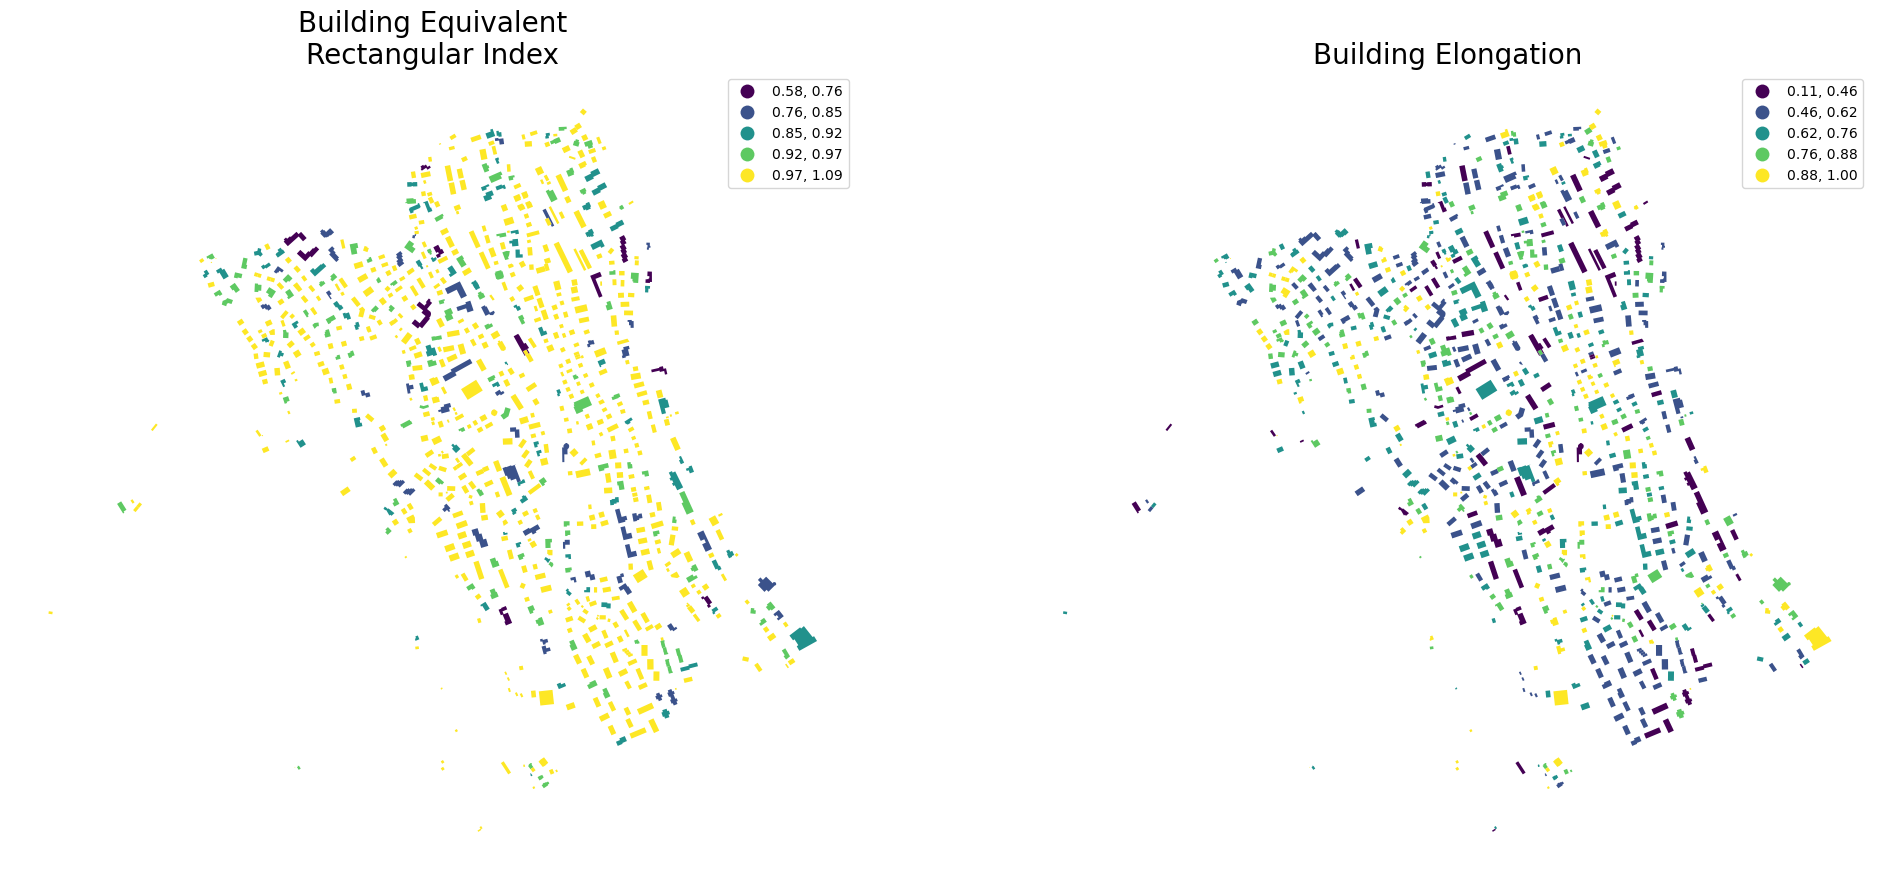

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Building Equivalent\nRectangular Index', fontsize=20)
ax[1].set_title('Building Elongation', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Oberrieden/eri_and_elongation.svg')  

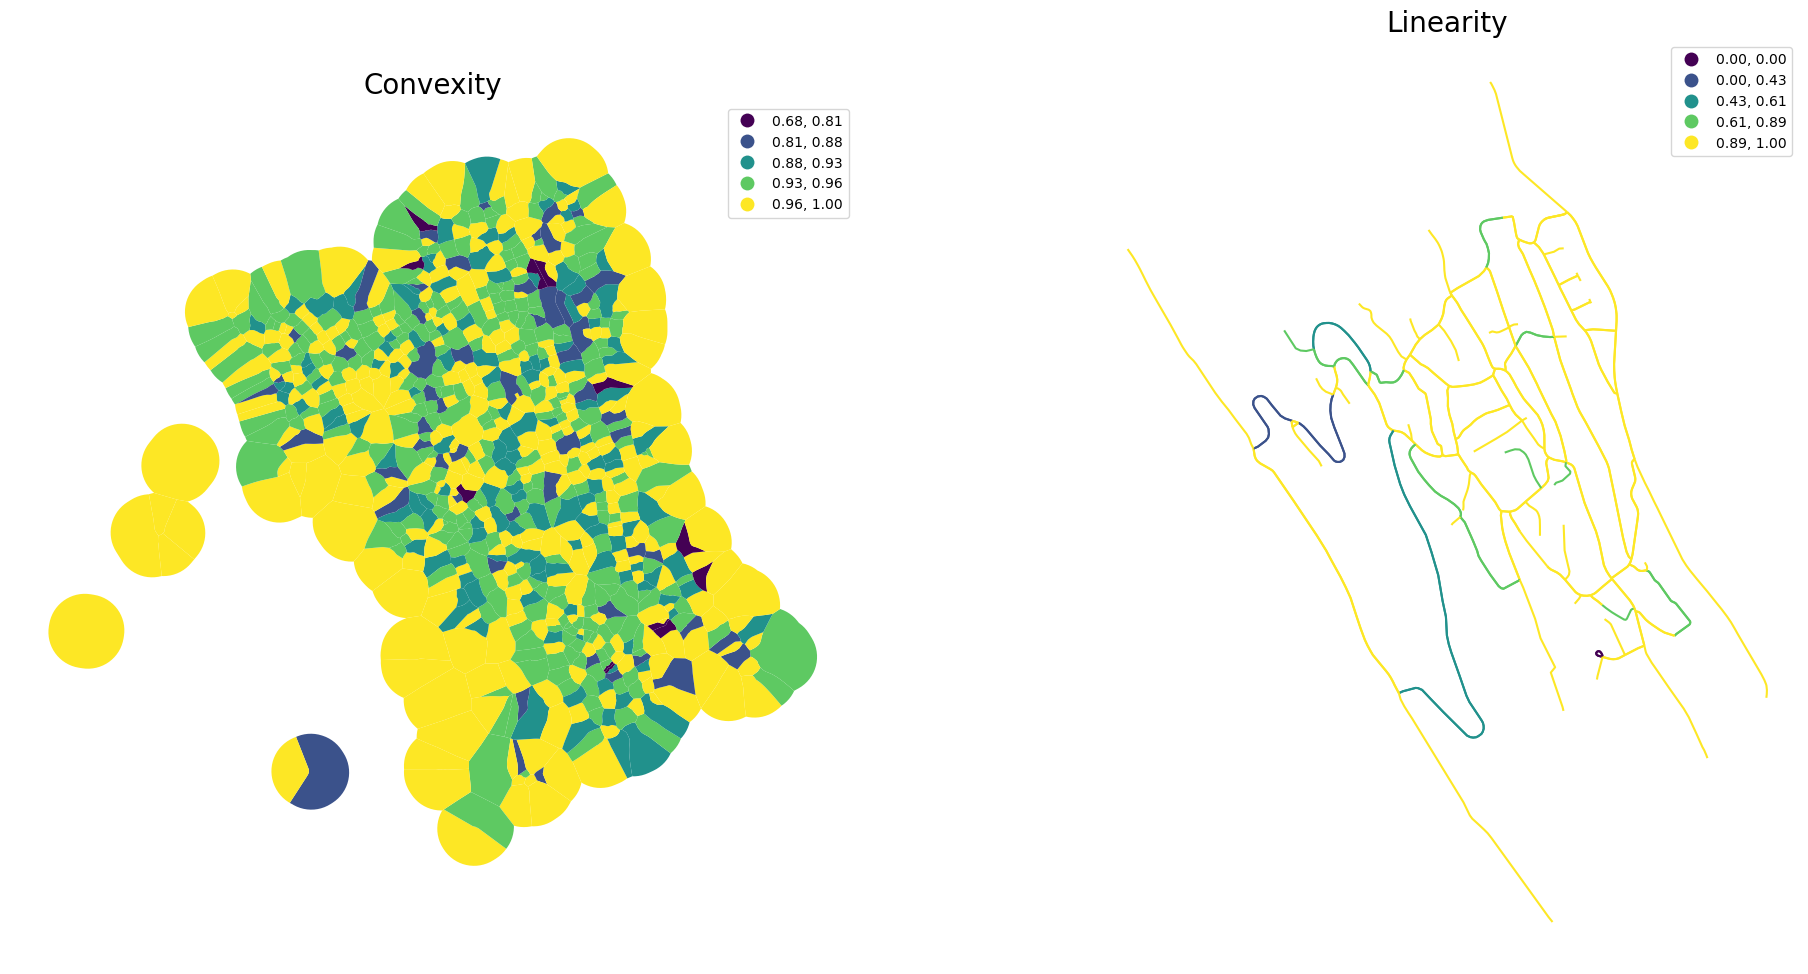

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Linearity', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Oberrieden/convexity_and_linearity.svg')  

### Spatial distribution

In [30]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/momepy/distribution.py:214: FutureWarning: Class based API like `momepy.SharedWalls` or `momepy.SharedWallsRatio` is deprecated. Replace it with `momepy.shared_walls` or explicitly computing `momepy.shared_walls / gdf.length` respectively to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  super().__init__(gdf)


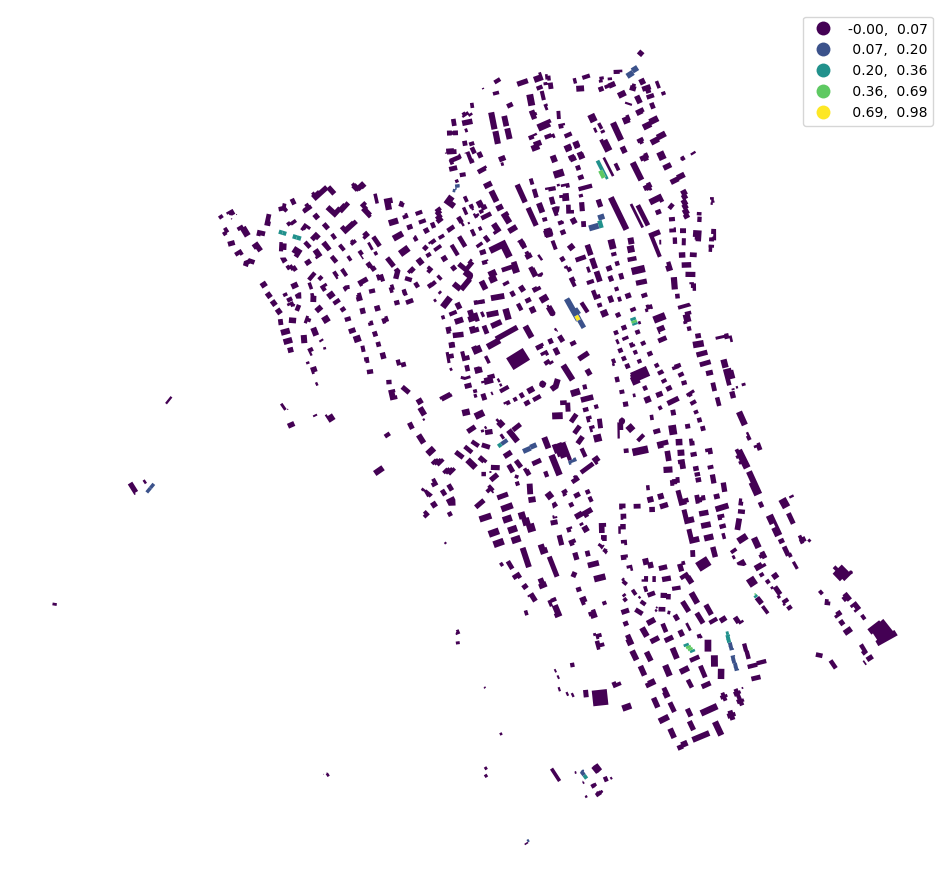

In [31]:
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

plt.savefig('../results/Oberrieden/sharedwalls.svg')  

Generate spatial weights matrix using `libpysal`.

In [32]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [33]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/1669107924.py:1: FutureWarning: Class based API like `momepy.Neighbors` is deprecated. Replace it with `momepy.neighbors` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/1669107924.py:2: FutureWarning: `momepy.CoveredArea` is deprecated. Replace it with `.describe()` method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series


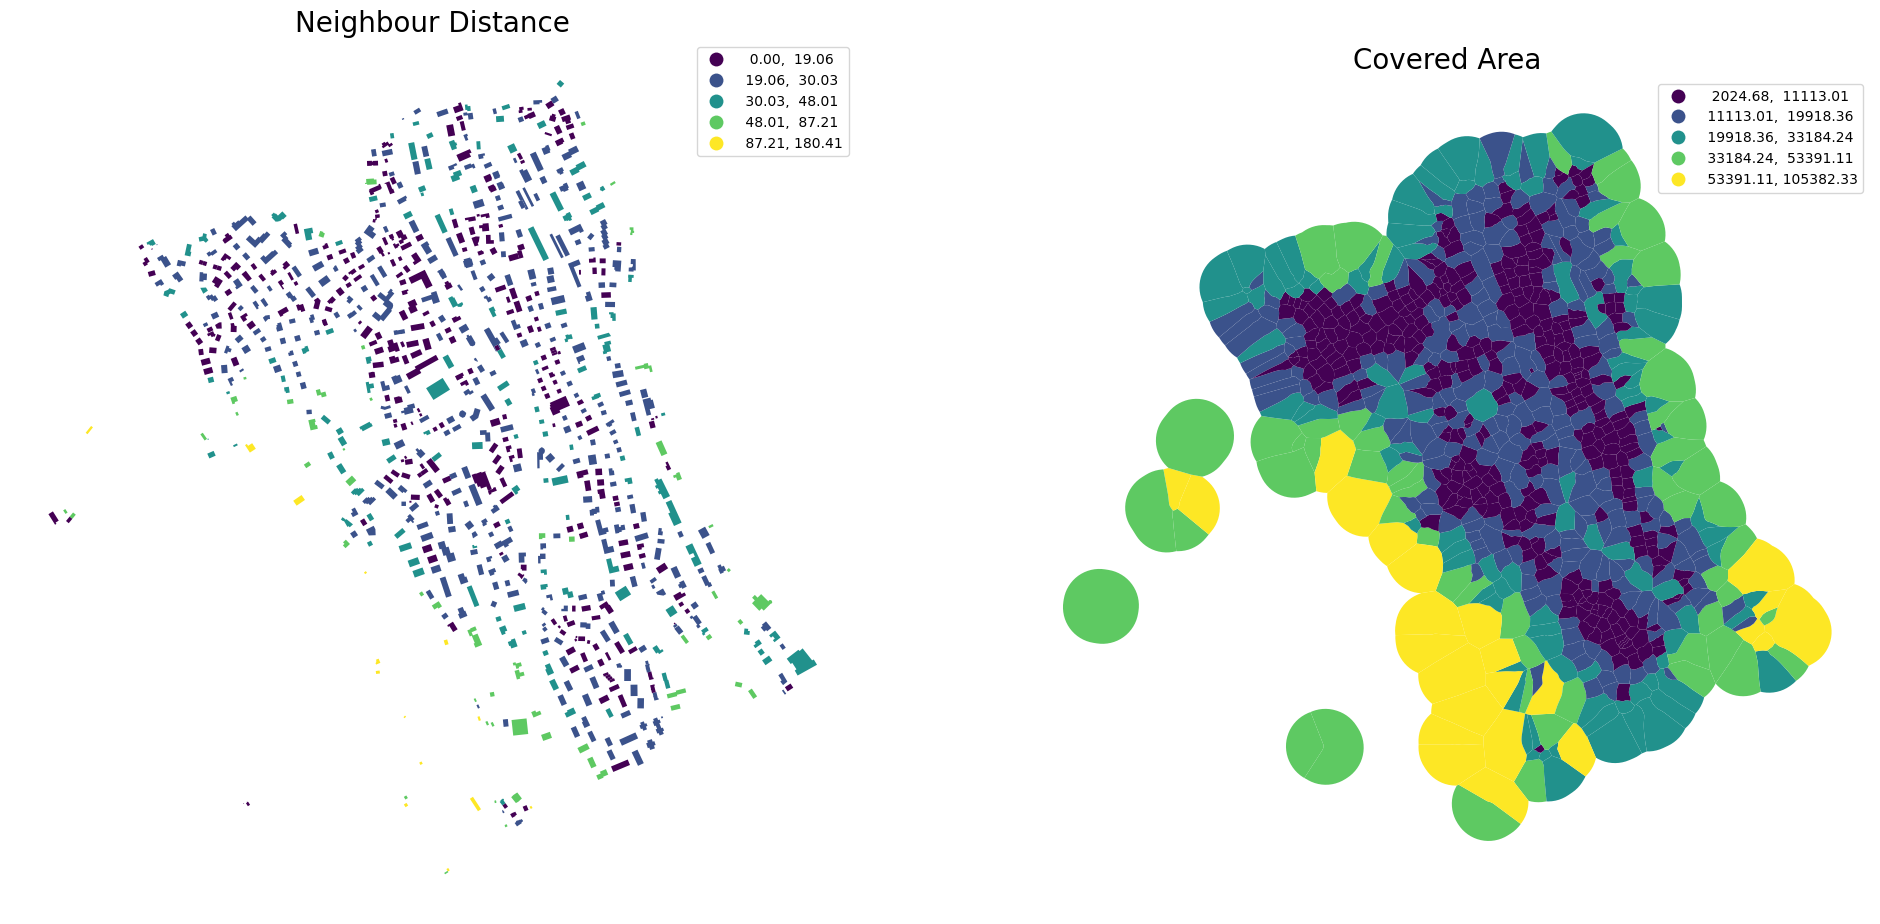

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Neighbour Distance', fontsize=20)
ax[1].set_title('Covered Area', fontsize=20)


ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Oberrieden/neighbourdist_and_coveredarea.svg')  

In [35]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/3221532125.py:1: FutureWarning: `momepy.sw_high` is deprecated. Replace it with .higher_order() method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  queen_3 = momepy.sw_high(k=3, weights=queen_1)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/3221532125.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/3221532125.py:4: FutureWarning: Class based API like `momepy.MeanInterbuildingDistance` is deprecated. Replace it with `momepy.mean_interbuilding_distance` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['interbuilding_distance'] 

In [36]:
#fig, ax = plt.subplots(1, 2, figsize=(24, 12))
#
#buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
#buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)
#
#ax[0].set_axis_off()
#ax[1].set_axis_off()

In [37]:
profile = momepy.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/2648127835.py:1: FutureWarning: Class based API like `momepy.StreetProfile` is deprecated. Replace it with `momepy.street_profile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  profile = momepy.StreetProfile(streets, buildings)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in intersection
  return getattr(ufunc, method)(*new_inputs, **kwargs)


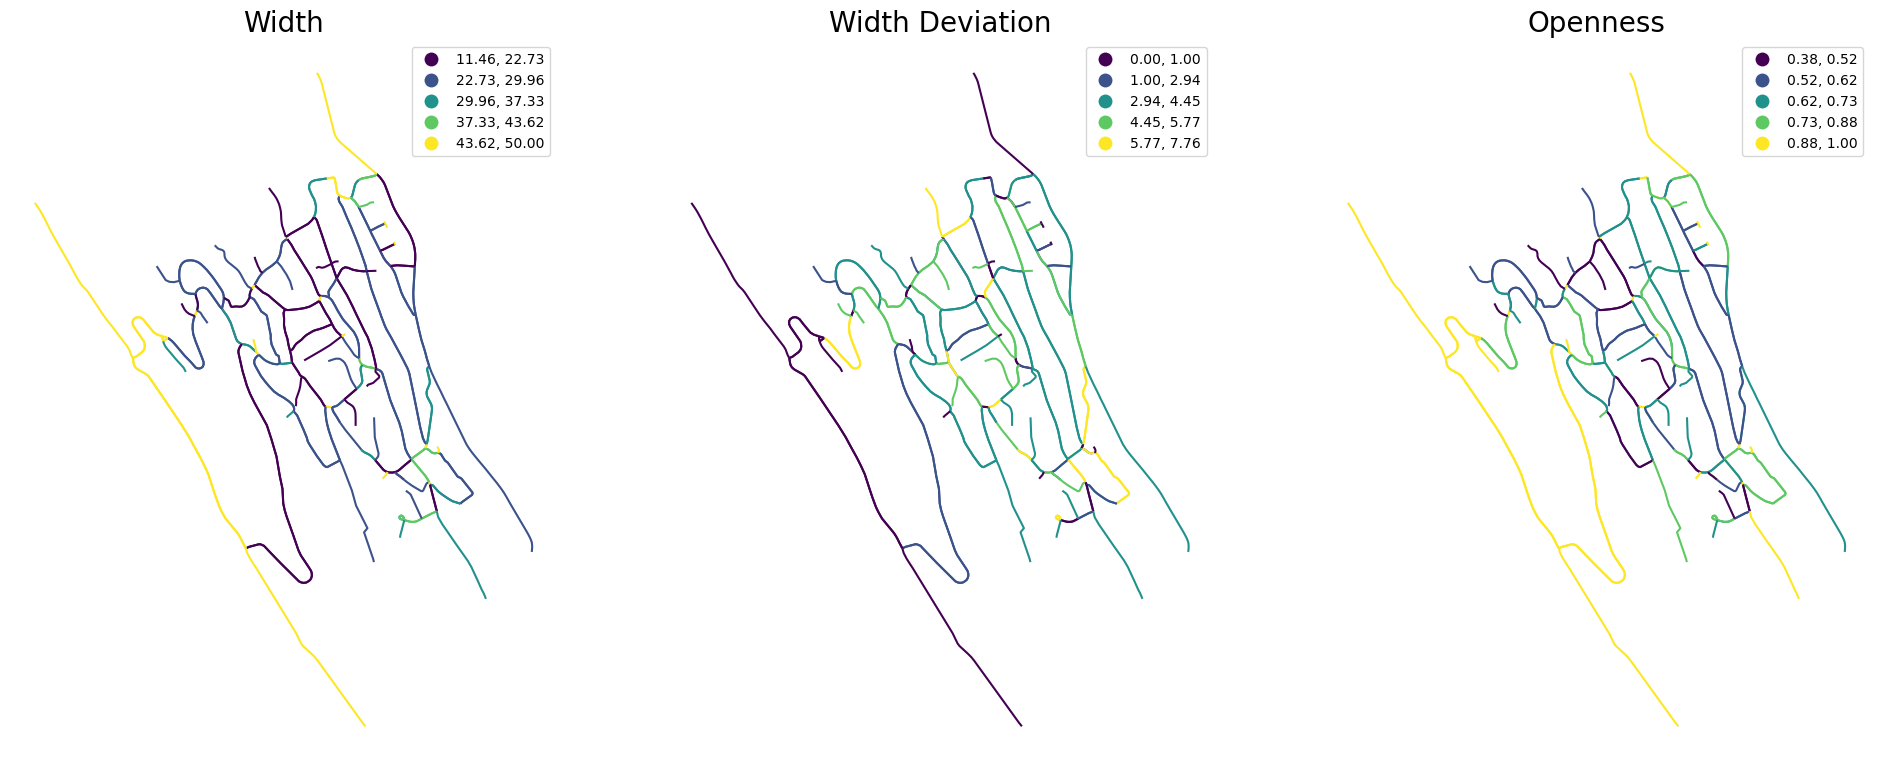

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_title('Width', fontsize=20)
ax[1].set_title('Width Deviation', fontsize=20)
ax[2].set_title('Openness', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Oberrieden/road_network.svg')  

### Intensity

In [39]:
tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/1819725789.py:1: FutureWarning: `momepy.AreaRatio` is deprecated. Replace it with a direct division of areas or momepy.describe_agg() or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series


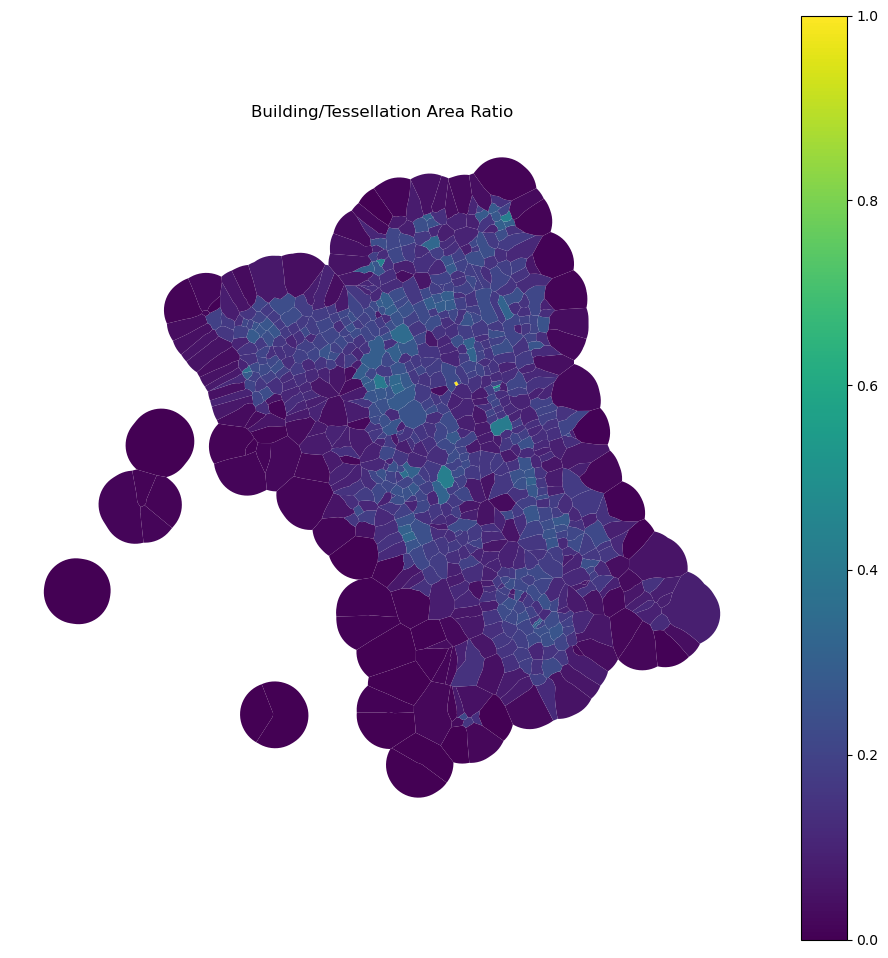

In [40]:
tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()
plt.title("Building/Tessellation Area Ratio")

plt.savefig('../results/Oberrieden/tessellation_ratio.svg')  

### Connectivity

In [41]:
graph = momepy.gdf_to_nx(streets)

In [42]:
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

In [43]:
nodes, streets = momepy.nx_to_gdf(graph)

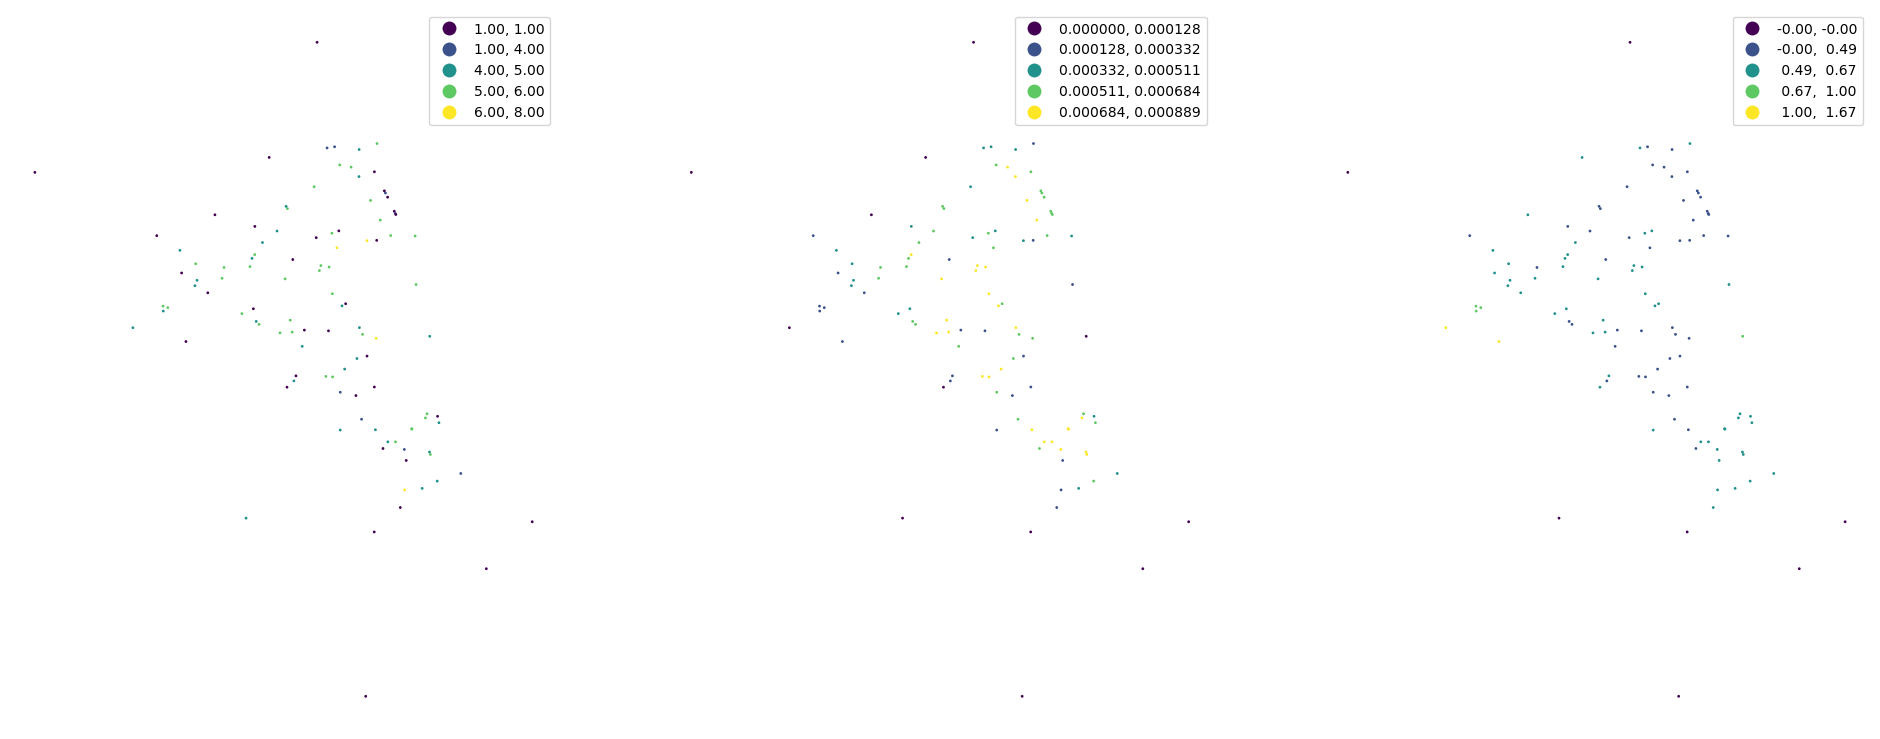

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Oberrieden/connectivity.svg')  

In [45]:
buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/403706460.py:1: FutureWarning: Class based API like `momepy.get_node_id` is deprecated. Replace it with `momepy.get_nearest_node` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")


  0%|          | 0/844 [00:00<?, ?it/s]

Link all data together (to tessellation cells or buildings).

In [46]:
tessellation

,uID,geometry,nID,area,convexity,neighbors,covered_area,car
0,734,"POLYGON ((2685973.188 1235677.899, 2686044.271...",111,17191.392015,0.992737,0.003778,47865.385431,0.001916
1,820,"POLYGON ((2686135.257 1235674.822, 2686134.568...",211,7689.406967,0.990258,0.014539,50541.503088,0.003765
2,345,"POLYGON ((2686197.645 1235748.423, 2686196.588...",211,744.761955,0.978243,0.057250,27103.304045,0.158088
3,817,"POLYGON ((2686160.261 1235743.424, 2686162.388...",211,854.588998,0.983251,0.051459,30969.604088,0.026589
4,816,"POLYGON ((2686190.041 1235771.496, 2686189.128...",211,374.901466,0.954621,0.048503,10552.099159,0.226083
...,...,...,...,...,...,...,...,...
839,228,"POLYGON ((2685568.599 1237092.793, 2685567.746...",195,12855.879494,0.959069,0.011158,37327.141806,0.064310
840,729,"POLYGON ((2685323.954 1237030.597, 2685321.566...",191,11052.546482,0.988287,0.007244,25466.419362,0.007841
841,201,"POLYGON ((2685353.831 1237103.830, 2685351.276...",191,8532.917192,0.969222,0.013680,30106.366221,0.021586
842,810,"POLYGON ((2685932.903 1237344.416, 2685931.752...",44,5831.143978,0.995861,0.009219,21733.754550,0.002558


In [47]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

In [48]:
merged.columns

Index(['uID', 'geometry', 'nID', 'area_x', 'convexity', 'neighbors',
       'covered_area', 'car', 'area_y', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'nodeID',
       'length', 'linearity', 'width', 'width_deviation', 'openness', 'mm_len',
       'node_start', 'node_end', 'x', 'y', 'degree', 'closeness',
       'meshedness'],
      dtype='object')

## Understanding the context

Measure first, second and third quartile of distribution of values within an area around each building.

In [49]:
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42725/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API

In [50]:
percentiles_joined = pandas.concat(percentiles, axis=1)

In [51]:
percentiles_joined

,area_x_25,area_x_50,area_x_75,convexity_25,convexity_50,convexity_75,neighbors_25,neighbors_50,neighbors_75,covered_area_25,...,y_75,degree_25,degree_50,degree_75,closeness_25,closeness_50,closeness_75,meshedness_25,meshedness_50,meshedness_75
0,2783.140452,8592.511494,15014.618568,0.953947,0.986487,0.991728,0.007761,0.014539,0.021216,30861.324641,...,1.235853e+06,1.0,1.0,5.0,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000
1,2336.771671,6421.961619,9845.575523,0.949163,0.976945,0.990978,0.011660,0.018537,0.022778,29968.414961,...,1.235853e+06,1.0,1.0,5.0,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000
2,2197.290275,4719.804202,9603.888527,0.949163,0.972796,0.989277,0.013200,0.020060,0.024048,29023.975865,...,1.235853e+06,1.0,1.0,5.0,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
3,2149.453503,6671.104667,9845.575523,0.949163,0.980747,0.991728,0.011660,0.019529,0.024048,29023.975865,...,1.235853e+06,1.0,1.0,5.0,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000
4,2180.748736,4505.122119,9501.556146,0.948700,0.969022,0.988662,0.013374,0.020522,0.024306,28455.122012,...,1.235853e+06,1.0,1.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,970.542134,1590.402152,3912.297658,0.947513,0.960842,0.970868,0.017609,0.040458,0.047214,8191.659867,...,1.237075e+06,1.0,5.0,5.0,0.000347,0.000347,0.000429,0.515152,0.538462,0.538462
840,1361.181786,3799.191378,5358.067786,0.942626,0.962813,0.986652,0.012115,0.023996,0.037779,17676.614641,...,1.237036e+06,1.0,1.0,5.0,0.000187,0.000187,0.000347,0.444444,0.444444,0.538462
841,1119.184247,1982.440006,5200.916854,0.944657,0.960715,0.983153,0.012166,0.030527,0.046044,11875.778799,...,1.237036e+06,1.0,5.0,5.0,0.000187,0.000347,0.000347,0.444444,0.538462,0.538462
842,1669.556261,1907.809182,5172.416413,0.926031,0.955802,0.962791,0.014784,0.033330,0.037547,13921.705222,...,1.237383e+06,4.0,4.5,6.0,0.000426,0.000444,0.000463,0.440000,0.505714,0.571429


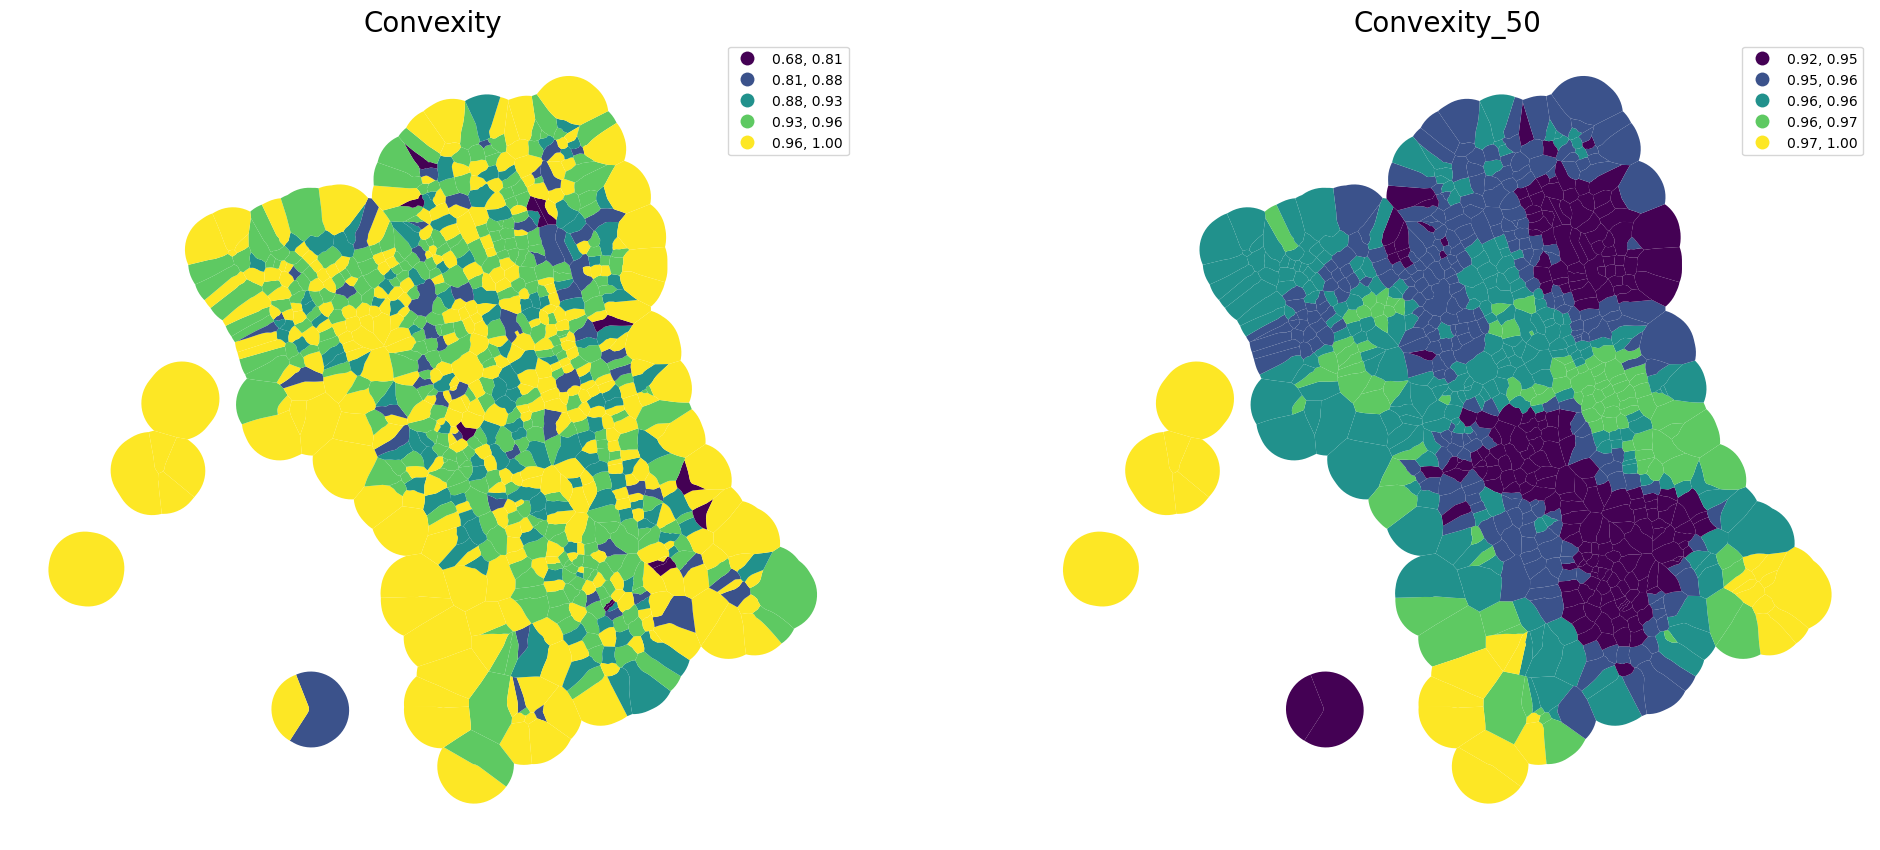

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Convexity_50', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Oberrieden/convexity.svg')  

## Clustering

Standardize values before clustering.

In [53]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()

In [54]:
standardized

,area_x_25,area_x_50,area_x_75,convexity_25,convexity_50,convexity_75,neighbors_25,neighbors_50,neighbors_75,covered_area_25,...,y_75,degree_25,degree_50,degree_75,closeness_25,closeness_50,closeness_75,meshedness_25,meshedness_50,meshedness_75
0,1.048666,3.819267,4.481297,1.876113,3.496876,2.374010,-2.766117,-3.210298,-3.050655,3.798578,...,-2.325323,-1.789767,-3.676955,-1.242475,-2.005323,-2.751987,-3.784139,-2.603699,-3.347934,-3.546388
1,0.754592,2.608840,2.565487,1.503276,2.420822,2.274802,-2.275522,-2.648183,-2.844407,3.633534,...,-2.325323,-1.789767,-3.676955,-1.242475,-2.005323,-2.751987,-3.784139,-2.603699,-3.347934,-3.546388
2,0.662699,1.659617,2.475910,1.503276,1.952932,2.049580,-2.081643,-2.434079,-2.676726,3.458967,...,-2.325323,-1.789767,-3.676955,-1.242475,-2.005323,-2.751987,-3.784139,-2.603699,-3.347934,-3.546388
3,0.631184,2.747777,2.565487,1.503276,2.849563,2.374010,-2.275522,-2.508712,-2.676726,3.458967,...,-2.325323,-1.789767,-3.676955,-1.242475,-2.005323,-2.751987,-3.784139,-2.603699,-3.347934,-3.546388
4,0.651801,1.539897,2.437982,1.467244,1.527361,1.968180,-2.059756,-2.369242,-2.642693,3.353821,...,-2.325323,-1.789767,-3.676955,-1.242475,-2.005323,-2.751987,-3.784139,-2.603699,-3.347934,-3.546388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,-0.145501,-0.085523,0.366427,1.374686,0.604859,-0.387099,-1.526856,0.433273,0.381910,-0.391625,...,0.825006,-1.789767,-0.314257,-1.242475,-0.132099,-0.854513,-1.099920,0.481516,0.309082,-0.173820
840,0.111859,1.146229,0.902275,0.993897,0.827043,1.702163,-2.218173,-1.880867,-0.863708,1.361550,...,0.724890,-1.789767,-3.676955,-1.242475,-0.995106,-1.728692,-1.613474,0.058056,-0.329444,-0.173820
841,-0.047573,0.133101,0.844030,1.152130,0.590456,1.238994,-2.211842,-0.962712,0.227434,0.289338,...,0.724890,-1.789767,-0.314257,-1.242475,-0.995106,-0.854513,-1.613474,0.058056,0.309082,-0.173820
842,0.315020,0.091482,0.833467,-0.299353,0.036398,-1.456252,-1.882373,-0.568711,-0.894394,0.667502,...,1.620889,-0.148742,-0.734594,0.048170,0.293522,-0.322304,-0.889007,0.031438,0.086676,0.032664


### How many clusters?

In [55]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=0)
cgram.fit(standardized.fillna(0))

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.019 seconds.
K=3 fitted in 0.022 seconds.
K=4 fitted in 0.025 seconds.
K=5 fitted in 0.024 seconds.
K=6 fitted in 0.023 seconds.
K=7 fitted in 0.033 seconds.
K=8 fitted in 0.024 seconds.
K=9 fitted in 0.027 seconds.
K=10 fitted in 0.046 seconds.
K=11 fitted in 0.058 seconds.


Clustergram(k_range=range(1, 12), backend='sklearn', method='kmeans', kwargs={'n_init': 10, 'random_state': 0})

In [56]:
show(cgram.bokeh())

In [57]:
cgram.labels.head()

,1,2,3,4,5,6,7,8,9,10,11
0,0,1,2,2,2,2,2,1,1,2,9
1,0,1,2,2,2,2,2,1,1,2,9
2,0,1,2,2,2,2,2,1,1,2,9
3,0,1,2,2,2,2,2,1,1,2,9
4,0,1,2,2,2,2,2,1,1,2,9


In [58]:
merged["cluster"] = cgram.labels[8].values

In [59]:
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")

In [60]:
urban_types.explore("cluster", categorical=True, prefer_canvas=True, tiles="CartoDB Positron", tooltip=False)

## Export

Save cluster output geodata to geojson file:

In [61]:
urban_types.to_file('../data/raw/Oberrieden.geojson', driver='GeoJSON')

## Utilities

Once you run the cell below, it hides all cells below the currently active one (aka presentation mode).

In [ ]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: none;
}
</style>

Run this cell to turn the presentation mode off.

In [ ]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: block;
}
</style>